In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
np.random.seed(42)
%matplotlib inline

In [2]:
pd.options.display.max_columns = 999

In [3]:
plt.rcParams['figure.figsize'] = (10,6)

## Week 12: Predictive Modeling Part 2
Nov 21, 2019


## Housekeeping

- Class is on Tuesday 11/26 next week (same time) because of Thanksgiving
- HW #7 (required) is due next week
    - Includes final project proposal

## Last time

- An introduction to supervised learning and regression with scikit learn
- **Example:** modeling housing prices in Philadelphia
- **Key concepts:**
    - Linear regression
    - Ridge regression with regularization 
    - Test/train split and $k$-fold cross validation
    - Feature engineering
        - Scaling input features
        - Adding polynomial features
        - One-hot encoding + categorical variables
    - Decision trees and random forests

## Today: Predictive modeling continued

**Focus**: much more hands-on experience with featuring engineering and adding spatial based features

- **Part 1:** Revisiting housing prices modeling
- **Part 2:** Predicting bikeshare demand in Philadelphia

## Why is feature engineering so important?

**Garbage in, garbage out**

- What we're trying to do is build the best possible model for a particular thing we care about, e.g., housing price, bikeshare trips, etc
- Our machine learning models try to translate from some set of input features to the thing we care about
- You should think of the input features as having *all of the same information* as the predicted quantity — *they are just a different representation*

**Takeway:** If your input features are poorly designed (for example, completely unrelated to thing you want to predict), then no matter how good your machine learning model is or how well you "train" it, then the model will never be able to do the translation from features to predicted value.

## Part 1: Adding spatial features to the housing price model

Recall:

- Modeling residential sale prices for sales in 2018 with data from the Office of Property Assessment
- Model included: property characteristics and ZIP code categorical variables
- Random forest model showed good improvement over standard linear regression (ordinary least squares)

**Let's do some additional feature engineering to see if we can improve the model's accuracy.**

First, let's setup all of the imports we'll need from scikit learn:

In [4]:
# Preprocessing/Setup
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor

# Model selection
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

## Let's load the same data as last week

Query the city's CARTO cloud database to pull the data for all residential sales in 2018:

In [5]:
import carto2gpd

In [8]:
# the CARTO API url
carto_url = "https://phl.carto.com/api/v2/sql"

# The table name
table_name = "opa_properties_public"

# Only pull 2018 sales for single family residential properties
where = "sale_date >= '2018-01-01' and sale_date < '2019-01-01' and category_code_description = 'Single Family'"

# Run the query
salesRaw = carto2gpd.get(carto_url, table_name, where=where)

In [9]:
salesRaw.head()

geometry assessment_date basements  \
0  POINT (-75.15507 39.92678)            None         A   
1  POINT (-75.15522 39.92680)            None         C   
2  POINT (-75.15238 39.92815)            None         D   
3  POINT (-75.15242 39.92798)            None         D   
4  POINT (-75.16185 39.92652)            None         D   

             beginning_point book_and_page building_code  \
0  233' W 5TH ST                   3458342         O30     
1  275 FT W 5 ST                   3447372         O30     
2  48'6" S TASKER ST               3400021         O50     
3  112'6" S TASKER ST              3349209         O50     
4  322' W OF 9TH                   3381568         P30     

  building_code_description category_code category_code_description  \
0         ROW 2 STY MASONRY             1             Single Family   
1         ROW 2 STY MASONRY             1             Single Family   
2         ROW 3 STY MASONRY             1             Single Family   
3         ROW 3 STY MASONRY             1             Single Family   
4   ROW W/GAR 2 STY MASONRY             1             Single Family   

  census_tract central_air cross_reference date_exterior_condition  depth  \
0          741           Y            None                    None  49.75   
1          741           N            None                    None  50.00   
2          750           Y            None                    None  65.17   
3          750           Y            None                    None  63.17   
4          840           Y            None                    None  60.83   

   exempt_building  exempt_land exterior_condition  fireplaces  frontage  \
0         179560.0          0.0                  2           0     13.93   
1          45000.0          0.0                  4           0     14.02   
2          45000.0          0.0                  2           0     16.00   
3          45000.0          0.0                  4           0     16.00   
4          45000.0          0.0                  4           0     14.00   

   fuel  garage_spaces garage_type general_construction geographic_ward  \
0  None              0           0                    A              01   
1  None              0           0                    A              01   
2  None              0           0                    A              01   
3  None              0           0                    A              01   
4  None              3           A                    A              01   

   homestead_exemption house_extension house_number interior_condition  \
0                  0.0              00        00527                  2   
1              45000.0              00        00533                  4   
2              45000.0              00        01606                  2   
3              45000.0              00        01614                  4   
4              45000.0              00        00938                  4   

            location mailing_address_1 mailing_address_2 mailing_care_of  \
0      527 PIERCE ST              None              None            None   
1      533 PIERCE ST              None              None            None   
2      1606 S 4TH ST              None              None            None   
3      1614 S 4TH ST              None              None            None   
4  938 MC CLELLAN ST              None              None            None   

  mailing_city_state             mailing_street mailing_zip  market_value  \
0               None                       None        None      303400.0   
1    PHILADELPHIA PA  531 PIERCE ST                   19148      161200.0   
2               None                       None        None      416500.0   
3               None                       None        None      436600.0   
4               None                       None        None      285100.0   

  market_value_date  number_of_bathrooms  number_of_bedrooms  number_of_rooms  \
0              None                    2                   2 

In [10]:
len(salesRaw)

27216

## Clean the raw data

- Remove features with a large number of missing values
- Format the ZIP code column
- Trim to sales between \\$3,000 and \\$1 million

In [11]:
# The feature columns we want to use
cols = [
    "sale_price",
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "exterior_condition",
    "zip_code",
    "geometry"
]

# Trim to these columns and remove NaNs
sales = salesRaw[cols].dropna()

# Trim zip code to only the first five digits
sales['zip_code'] = sales['zip_code'].astype(str).str.slice(0, 5)

In [12]:
# Trim very low and very high sales
valid = (sales['sale_price'] > 3000) & (sales['sale_price'] < 1e6)
sales = sales.loc[valid]

In [13]:
len(sales)

21550

## Remember: One-hot encoding in scikit learn

- The [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) object is a preprocessor that will perform the vectorization step
- The [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) object will help us apply different transformers to numerical and categorical columns

In [14]:
# Numerical columns
num_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
]

# Categorical columns
cat_cols = ["exterior_condition", "zip_code"]

In [15]:
# Set up the column transformer with two transformers
# Scale the numerical columns and one-hot 
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

In [16]:
# Initialize the pipeline
# NOTE: only use 20 estimators here so it will run in a reasonable time
regr = make_pipeline(
    preprocessor, RandomForestRegressor(n_estimators=20, random_state=42)
)

## Now, let's fit the model (same as last week)

- Use a 70%/30% train/test split — 30% of data is reserved for final testing
- Use the log of the sale price as the target values to regress

In [17]:
# Split the data 70/30
train_set, test_set = train_test_split(sales, test_size=0.3, random_state=42)

# the target labels
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

In [18]:
# Fit the training set
regr.fit(train_set, y_train);

In [19]:
# What's the test score?
regr.score(test_set, y_test)

0.6588076910790797

## Let's plot the top 30 importances

To do so, remember, we'll need to get the names of the columns created during the one-hot encoding process...

In [20]:
# The one-hot step
ohe = preprocessor.named_transformers_['cat']

# One column for each category type!
ohe_cols = ohe.get_feature_names()

# Full list of columns is numerical + one-hot
features = num_cols + list(ohe_cols)

In [21]:
features

['total_livable_area',
 'total_area',
 'garage_spaces',
 'fireplaces',
 'number_of_bathrooms',
 'number_of_bedrooms',
 'number_stories',
 'x0_0',
 'x0_1',
 'x0_2',
 'x0_3',
 'x0_4',
 'x0_5',
 'x0_6',
 'x0_7',
 'x1_19102',
 'x1_19103',
 'x1_19104',
 'x1_19106',
 'x1_19107',
 'x1_19111',
 'x1_19114',
 'x1_19115',
 'x1_19116',
 'x1_19118',
 'x1_19119',
 'x1_19120',
 'x1_19121',
 'x1_19122',
 'x1_19123',
 'x1_19124',
 'x1_19125',
 'x1_19126',
 'x1_19127',
 'x1_19128',
 'x1_19129',
 'x1_19130',
 'x1_19131',
 'x1_19132',
 'x1_19133',
 'x1_19134',
 'x1_19135',
 'x1_19136',
 'x1_19137',
 'x1_19138',
 'x1_19139',
 'x1_19140',
 'x1_19141',
 'x1_19142',
 'x1_19143',
 'x1_19144',
 'x1_19145',
 'x1_19146',
 'x1_19147',
 'x1_19148',
 'x1_19149',
 'x1_19150',
 'x1_19151',
 'x1_19152',
 'x1_19153',
 'x1_19154']

In [22]:
import hvplot.pandas

In [23]:
regressor = regr["randomforestregressor"]

# Create the dataframe with importances
importance = pd.DataFrame(
    {"Feature": features, "Importance": regressor.feature_importances_}
)

# Sort by importance and get the top 30
# MAKE SURE TO SORT IN DESCENDING ORDER!!
importance = importance.sort_values("Importance", ascending=False).iloc[:50]

# Plot
importance.hvplot.barh(
    x="Feature", y="Importance", height=700, flip_yaxis=True
)

:Bars   [Feature]   (Importance)

## Improving the model even further

- Adding in ZIP code information captures a lot of the neighborhood-based amenity/disamenity properties
- Can we explicitly add new features that also try to capture some of those features?

**Yes, let's add distance-based features**

## Spatial amenity/disamenity features

**The strategy**

- Get the data for a certain type of amenity, e.g., restaurants, bars, or disamenity, e.g., crimes
    - Data sources: 311 requests, crime incidents, Open Street Map
- Use scikit learn's nearest neighbor algorithm to calculate the distance from each sale to its nearest neighbor in the amenity/disamenity datasets

## Examples of new possible features...

Distance from each sale to:

- Universities
- Parks
- City Hall
- Subway Stops
- New Construction Permits
- Aggravated Assaults
- Graffiti 311 Calls
- Abandoned Vehicle 311 Calls

## Example #1: 311 Graffiti Calls

Source: https://www.opendataphilly.org/dataset/311-service-and-information-requests

### Step 1: Download the data from the CARTO database


We'll only pull data from 2018.

In [24]:
# the 311 table
table_name = "public_cases_fc"

# Peak at the first row of data
carto2gpd.get(carto_url, table_name, limit=1)

geometry  objectid  service_request_id  status  \
0  POINT (-75.23848 39.96587)         2             8967058  Closed   

     status_notes       service_name service_code agency_responsible  \
0  Issue Resolved  Abandoned Vehicle      SR-PD01  Police Department   

     service_notice    requested_datetime      updated_datetime  \
0  30 Business Days  2015-01-11T00:00:00Z  2015-08-12T00:00:00Z   

      expected_datetime         address zipcode  \
0  2015-02-19T00:00:00Z  5915 SUMMER ST    None   

                                           media_url        lat        lon  
0  https://d21tc4b3k3r3vo.cloudfront.net/uploads/...  39.965869 -75.238483

In [25]:
# Select only those for grafitti and in 2018
where_2018 = "requested_datetime >= '01-01-2018' and requested_datetime < '01-01-2019'"
where_grafitti = "service_name = 'Graffiti Removal'"
where = f"{where_2018} and {where_grafitti}"
 
# Pull the subset we want
graffiti = carto2gpd.get(carto_url, table_name, where=where)

In [26]:
# Remove rows with missing geometries
graffiti = graffiti.loc[graffiti.geometry.notnull()]

In [27]:
len(graffiti)

18136

In [28]:
graffiti.head()

geometry  objectid  service_request_id  status  \
0  POINT (-75.15816 39.93628)   4840442            12097785  Closed   
1  POINT (-75.16608 39.94058)   3970721            11929387  Closed   
2  POINT (-75.16608 39.94058)   3970722            11929386  Closed   
3  POINT (-75.21793 39.95227)   4753586            12056802  Closed   
4  POINT (-75.04207 40.02494)   4384412            12028466  Closed   

       status_notes      service_name service_code  \
0    Issue Resolved  Graffiti Removal      SR-CL01   
1    Issue Resolved  Graffiti Removal      SR-CL01   
2    Issue Resolved  Graffiti Removal      SR-CL01   
3    Issue Resolved  Graffiti Removal      SR-CL01   
4  Repair Completed  Graffiti Removal      SR-CL01   

                   agency_responsible   service_notice    requested_datetime  \
0  Community Life Improvement Program  7 Business Days  2018-07-17T00:00:00Z   
1  Community Life Improvement Program  7 Business Days  2018-04-22T00:00:00Z   
2  Community Life Improvement Program  7 Business Days  2018-04-22T00:00:00Z   
3  Community Life Improvement Program  7 Business Days  2018-06-24T00:00:00Z   
4  Community Life Improvement Program  7 Business Days  2018-06-07T00:00:00Z   

       updated_datetime     expected_datetime             address zipcode  \
0  2018-07-19T00:00:00Z  2018-07-26T00:00:00Z  848 WASHINGTON AVE    None   
1  2018-04-25T00:00:00Z  2018-05-01T00:00:00Z      801 S BROAD ST    None   
2  2018-04-25T00:00:00Z  2018-05-01T00:00:00Z      801 S BROAD ST    None   
3  2018-06-29T00:00:00Z  2018-07-03T00:00:00Z        4742 PINE ST    None   
4  2018-06-11T00:00:00Z  2018-06-18T00:00:00Z  4801 LONGSHORE AVE    None   

                                           media_url        lat        lon  
0  https://d17aqltn7cihbm.cloudfront.net/uploads/...  39.936281 -75.158160  
1  https://d17aqltn7cihbm.cloudfront.net/uploads/...  39.940585 -75.166075  
2  https://d17aqltn7cihbm.cloudfront.net/uploads/...  39.940585 -75.166075  
3  https://d17aqltn7cihbm.cloudfront.net/uploads/...  39.952272 -75.217926  
4                                               None  40.024944 -75.042071

### Step 2: Get the x/y coordinates of both datasets

We will need to:

- We'll want distances in meters (rather than degrees), so we'll convert the CRS to EPSG=3857
- Extract out the x/y coordinates of the geometry column of each dataset (sales and grafitti calls)

In [29]:
# Do the CRS conversion
sales_3857 = sales.to_crs(epsg=3857)
graffiti_3857 = graffiti.to_crs(epsg=3857)

In [30]:
def get_xy_from_geometry(df):
    """
    Return a numpy array with two columns, where the 
    first holds the `x` geometry coordinate and the second 
    column holds the `y` geometry coordinate
    """
    x = df.geometry.x
    y = df.geometry.y
    
    return np.column_stack((x, y)) # stack as columns

In [31]:
# Extract x/y for sales
salesXY = get_xy_from_geometry(sales_3857)

# Extract x/y for grafitti calls
graffitiXY = get_xy_from_geometry(graffiti_3857)

In [32]:
salesXY.shape

(21550, 2)

In [33]:
graffitiXY.shape

(18136, 2)

### Step 3: Calculate the nearest neighbor distances

For this, we will use the $k$ nearest neighbors algorithm from scikit learn.

For each sale:
- Find the $k$ nearest neighbors in the second dataset (graffiti calls, crimes, etc)
- Calculate the average distance from the sale to those $k$ neighbors

In [34]:
from sklearn.neighbors import NearestNeighbors

In [35]:
# STEP 1: Initialize the algorithm
k = 5
nbrs = NearestNeighbors(n_neighbors=k)

# STEP 2: Fit the algorithm on the "neighbors" dataset
nbrs.fit(graffitiXY)

# STEP 3: Get distances for sale to 
grafDists, grafIndices = nbrs.kneighbors(salesXY) 

***Note:** I am using `k=5` here without any real justification. In practice, you would want to try a few different k values to try to identify the best value to use.

## What did we just calculate?

- `grafDists`: For each sale, the distances to the 5 nearest graffiti calls
    - This should have 5 columns and the same length as the sales dataset
- `grafIndices`: For each sale, the index of each of the neighbors in the original dataset
    - This allows you to access the original 311 graffiti data

In [36]:
print("length of sales = ", len(salesXY))
print("shape of grafDists = ", grafDists.shape)
print("shape of grafIndices = ", grafIndices.shape)

length of sales =  21550
shape of grafDists =  (21550, 5)
shape of grafIndices =  (21550, 5)


In [37]:
# The distances from the first sale to the 5 nearest neighbors
grafDists[0]

array([28.15452596, 58.65574893, 58.835758  , 58.835758  , 58.835758  ])

## Can we reproduce these distances?

In [38]:
salesXY[0]

array([-8366224.12293283,  4855308.28192868])

In [39]:
# The coordinates for the first sale
x0, y0 = salesXY[0]
x0, y0

(-8366224.12293283, 4855308.281928676)

In [40]:
# The indices for the 5 nearest graffiti calls
grafIndices[0]

array([ 5894, 17815,  8055, 18106, 13914])

In [41]:
# the graffiti neighbors
sale0_neighbors = graffitiXY[grafIndices[0]]
sale0_neighbors

array([[-8366196.40437962,  4855303.3464307 ],
       [-8366270.87711896,  4855343.70145665],
       [-8366279.33740026,  4855287.95930569],
       [-8366279.33740026,  4855287.95930569],
       [-8366279.33740026,  4855287.95930569]])

In [42]:
# Access the first and second column for x/y values
neighbors_x = sale0_neighbors[:,0]
neighbors_y = sale0_neighbors[:,1]

# The x/y differences between neighbors and first sale coordinates
dx = (neighbors_x - x0)
dy = (neighbors_y - y0)

# The Euclidean dist
manual_dists = (dx**2 + dy**2) ** 0.5

In [43]:
manual_dists

array([28.15452596, 58.65574893, 58.835758  , 58.835758  , 58.835758  ])

In [44]:
grafDists[0]

array([28.15452596, 58.65574893, 58.835758  , 58.835758  , 58.835758  ])

## Use the log of the average distance as the new feature

We'll average over the column axis (`axis=1`):

In [45]:
# Average distance to neighbors
avgGrafDist = grafDists.mean(axis=1)

# Set zero distances to be small, but nonzero
# IMPORTANT: THIS WILL AVOID INF DISTANCES WHEN DOING THE LOG
avgGrafDist[avgGrafDist==0] = 1e-5

# Calculate log of distances
sales['logDistGraffiti'] = np.log10(avgGrafDist)

In [46]:
sales.head()

sale_price  total_livable_area  total_area  garage_spaces  fireplaces  \
0      309000                 882      693.01              0           0   
1      145000                 700      701.00              0           0   
2      585000                1800     1042.72              0           0   
4      280000                1478      851.62              3           0   
5      335000                 991      712.79              0           0   

   number_of_bathrooms  number_of_bedrooms  number_stories exterior_condition  \
0                    2                   2               2                  2   
1                    1                   2               2                  4   
2                    2                   4               3                  2   
4                    1                   1               2                  4   
5                    2                   2               2                  2   

  zip_code                    geometry  logDistGraffiti  
0    19148  POINT (-75.15507 39.92678)         1.721510  
1    19148  POINT (-75.15522 39.92680)         1.652864  
2    19148  POINT (-75.15238 39.92815)         1.478724  
4    19148  POINT (-75.16185 39.92652)         2.056031  
5    19148  POINT (-75.16110 39.92627)         1.798241

## Let's plot a hex map of the new feature!

In [47]:
# Load the City Limits to plot too
import esri2gpd

# From OpenDataPhilly's page
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/City_Limits/FeatureServer/0"
city_limits = esri2gpd.get(url).to_crs(epsg=3857)

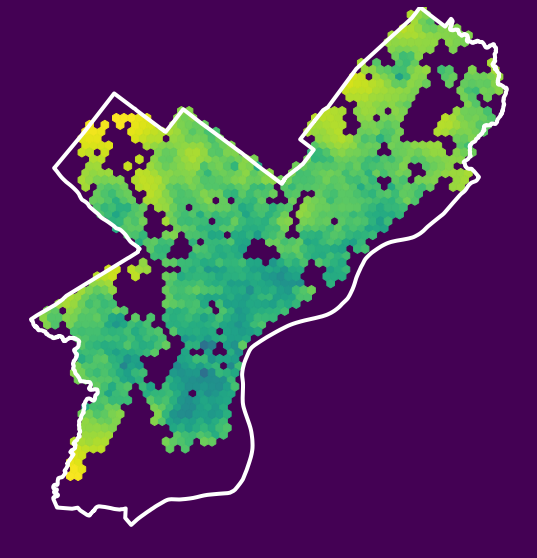

In [48]:
fig, ax = plt.subplots(figsize=(10,10), facecolor=plt.get_cmap('viridis')(0))

# Plot the log of the Graffiti distance
x = salesXY[:,0]
y = salesXY[:,1]
ax.hexbin(x, y, C=sales['logDistGraffiti'].values, gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")

## Example #2: Subway stops

We'll use a new package `osm2gpd` to pull subway stops from Open Street Map.

In [49]:
import osm2gpd

Similar syntax to the other packages to query CARTO and ESRI Map Servers (carto2gpd and esri2gpd)

In [50]:
osm2gpd.get?

What we need:

1. Bounding box in lat/lng to search within — we can use the city limits
1. The type of feature to search for.
    - For a full list, see: http://wiki.openstreetmap.org/wiki/Map_Features

In [51]:
# Bounding box from city limits
# CONVERT TO EPSG=4326 FIRST!
lng_min, lat_min, lng_max, lat_max = city_limits.to_crs(epsg=4326).total_bounds

In [52]:
# Grab subway stations
where="station=subway"

In [53]:
subway = osm2gpd.get(lng_min, lat_min, lng_max, lat_max, where=where).to_crs(epsg=3857)
subway.head()

lat        lon addr:city addr:state  \
id                                                     
326350578  39.943048 -75.119624    Camden         NJ   
469917199  39.945609 -75.121082       NaN        NaN   
650938316  39.962713 -75.246801       NaN        NaN   
650939214  39.962534 -75.259105       NaN        NaN   
650939615  39.964390 -75.252206       NaN        NaN   

                               addr:street internet_access  \
id                                                           
326350578  Martin Luther King Jr Boulevard            wlan   
469917199                              NaN             NaN   
650938316                              NaN             NaN   
650939214                              NaN             NaN   
650939615                              NaN             NaN   

          internet_access:fee                  name network operator  railway  \
id                                                                              
326350578                  no              Broadway   PATCO    PATCO  station   
469917199                 NaN             City Hall     NaN      NaN  station   
650938316                 NaN           63rd Street   SEPTA    SEPTA  station   
650939214                 NaN  69th Street Terminal   SEPTA    SEPTA  station   
650939615                 NaN            Millbourne   SEPTA    SEPTA  station   

          station  wikidata public_transport subway wheelchair  \
id                                                               
326350578  subway  Q7965918              NaN    NaN        NaN   
469917199  subway  Q5123196              NaN    NaN        NaN   
650938316  subway       NaN          station    yes        NaN   
650939214  subway  Q4642427          station    yes        yes   
650939615  subway  Q6858580          station    yes        NaN   

                               wikipedia operator_1 addr:housenumber  \
id                                                                     
326350578                            NaN        NaN              NaN   
469917199                            NaN        NaN              NaN   
650938316                            NaN        NaN              NaN   
650939214                            NaN        NaN              NaN   
650939615  en:Millbourne (SEPTA station)        NaN              NaN   

          platforms train old_name addr:postcode railway:traffic_mode tram  \
id                                                                           
326350578       NaN   NaN      NaN           NaN                  NaN  NaN   
469917199       NaN   NaN      NaN           NaN                  NaN  NaN   
650938316       NaN   NaN      NaN           NaN                  NaN  NaN   
650939214       NaN   NaN      NaN           NaN                  NaN  NaN   
650939615       NaN   NaN      NaN           NaN                  NaN  NaN   

          elevator                          geometry  
id                                                    
326350578      NaN  POINT (-8362278.281 4857669.589)  
469917199      NaN  POINT (-8362440.585 4858041.458)  
650938316      NaN  POINT (-8376435.605 4860525.356)  
650939214      NaN  POINT (-8377805.246 4860499.301)  
650939615      NaN  POINT (-8377037.309 4860768.923)

## Important: we need to trim to just Philadelphia

- Since we only supplied a rectangular bounding box, it's possible some features will be outside Philadelphia's city limits.
- We can do a spatial join with the city limits to find those featueres within the city bounds.

In [54]:
subway = gpd.sjoin(subway, city_limits, op="within")

## What data did we get?

The point locations of the Broad St. and Market-Frankford subway stops!

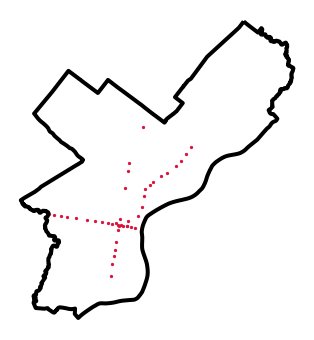

In [55]:
fig, ax = plt.subplots(figsize=(6,6))

# Plot the subway locations
subway.plot(ax=ax, markersize=5, color='crimson')

# City limits, too
city_limits.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=4)

ax.set_axis_off()

## Now, get the distances to the nearest subway stop

We'll use $k=1$ to get the distance to the nearest stop.

In [56]:
# STEP 1: x/y coordinates of subway stops (in EPGS=3857)
subwayXY = get_xy_from_geometry(subway.to_crs(epsg=3857))

# STEP 2: Initialize the algorithm
nbrs = NearestNeighbors(n_neighbors=1)

# STEP 3: Fit the algorithm on the "neighbors" dataset
nbrs.fit(subwayXY)

# STEP 4: Get distances for sale to neighbors
subwayDists, subwayIndices = nbrs.kneighbors(salesXY)

# STEP 5: add back to the original dataset
sales['logDistSubway'] = np.log10(subwayDists[:,0])

## Let's plot a hex map again!

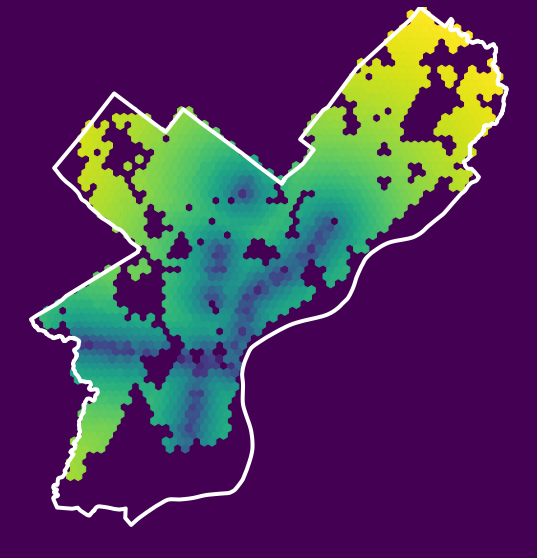

In [57]:
fig, ax = plt.subplots(figsize=(10,10), facecolor=plt.get_cmap('viridis')(0))

# Plot the log of the subway distance
x = salesXY[:,0]
y = salesXY[:,1]
ax.hexbin(x, y, C=np.log10(subwayDists.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")

## Looks like it worked!

## What about correlations?

Let's have a look at the correlations of numerical columns:

In [58]:
import seaborn as sns

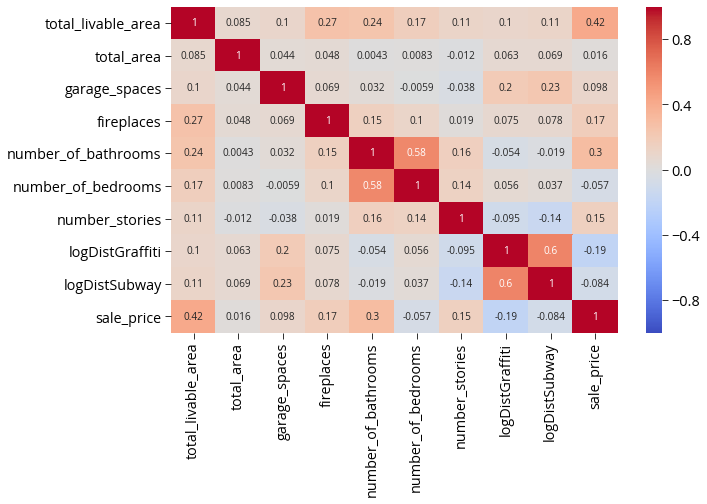

In [59]:
cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "logDistGraffiti",
    "logDistSubway", 
    "sale_price"
]
sns.heatmap(sales[cols].corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1);

# Now, let's re-run our model...did it help?

In [60]:
# Numerical columns
num_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "logDistGraffiti",
    "logDistSubway"
]

# Categorical columns
cat_cols = ["exterior_condition", "zip_code"]

In [61]:
# Set up the column transformer with two transformers
# Scale the numerical columns and one-hot 
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

In [62]:
# Initialize the pipeline
# NOTE: only use 20 estimators here so it will run in a reasonable time
regr = make_pipeline(
    preprocessor, RandomForestRegressor(n_estimators=20, random_state=42)
)

In [63]:
# Split the data 70/30
train_set, test_set = train_test_split(sales, test_size=0.3, random_state=42)

# the target labels
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

In [64]:
# Fit the training set
regr.fit(train_set, y_train);

In [65]:
# What's the test score?
regr.score(test_set, y_test)

0.7009034753125033

## Small improvement!

## How about the top 30 feature importances now?

In [66]:
def plot_feature_importances(regr, num_cols, preprocessor, top=20, **kwargs):
    """
    Utility function to plot the feature importances from the input
    random forest regressor
    """
    # The one-hot step
    ohe = preprocessor.named_transformers_["cat"]

    # One column for each category type!
    ohe_cols = ohe.get_feature_names()

    # Full list of columns is numerical + one-hot
    features = num_cols + list(ohe_cols)

    # The regressor
    regressor = regr["randomforestregressor"]

    # Create the dataframe with importances
    importance = pd.DataFrame(
        {"Feature": features, "Importance": regressor.feature_importances_}
    )

    # Sort importance in descending order and get the top
    importance = importance.sort_values("Importance", ascending=False).iloc[:top]

    # Plot
    return importance.hvplot.barh(x="Feature", y="Importance", flip_yaxis=True, **kwargs)

In [67]:
plot_feature_importances(regr, num_cols, preprocessor, top=30, height=500)

:Bars   [Feature]   (Importance)

## Both new spatial features are in the top 5 in terms of importance!

## Exercise: How about other spatial features?

- I've listed out several other types of potential sources of new distance-based features from OpenDataPhilly
- Choose a few and add new features
- Re-fit the model and evalute the performance on the test set and feature importances

Modify the `get_xy_from_geometry()` function to use the "centroid" of the geometry column.

**Note: you can take the centroid of a Point() or Polygon() object.** For a Point(), you just get the x/y coordinates back.

In [70]:
def get_xy_from_geometry(df):
    """
    Return a numpy array with two columns, where the 
    first holds the `x` geometry coordinate and the second 
    column holds the `y` geometry coordinate
    """
    # NEW: use the centroid.x and centroid.y to support Polygon() and Point() geometries 
    x = df.geometry.centroid.x
    y = df.geometry.centroid.y
    
    return np.column_stack((x, y)) # stack as columns

### Universities

New feature: Distance to the *nearest* university/college

- Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/philadelphia-universities-and-colleges)
- GeoService URL: https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Universities_Colleges/FeatureServer/0


In [71]:
# Get the data
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Universities_Colleges/FeatureServer/0"
univs = esri2gpd.get(url)

# Get the X/Y
univXY = get_xy_from_geometry(univs.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(univXY)
univDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales['logDistUniv'] = np.log10(univDists.mean(axis=1))

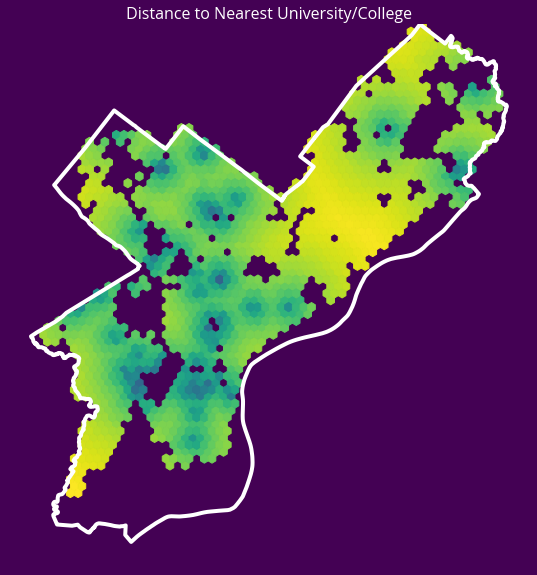

In [72]:
fig, ax = plt.subplots(figsize=(10,10), facecolor=plt.get_cmap('viridis')(0))

x = salesXY[:,0]
y = salesXY[:,1]
ax.hexbin(x, y, C=np.log10(univDists.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to Nearest University/College", fontsize=16, color='white');

### Parks

New feature: Distance to the *nearest* park centroid

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/parks-and-recreation-assets)
* GeoService URL: https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/PPR_Assets/FeatureServer/0

**Notes** 
- The park geometries are *polygons*, so you'll need to get the `x` and `y` coordinates of the park *centroids* and calculate the distance to these centroids. 
- You can use the `geometry.centroid.x` and `geometry.centroid.y` values to access these coordinates.

In [73]:
# Get the data
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/PPR_Assets/FeatureServer/0"
parks = esri2gpd.get(url)

# Get the X/Y
parksXY = get_xy_from_geometry(parks.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(parksXY)
parksDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales['logDistParks'] = np.log10(parksDists.mean(axis=1))

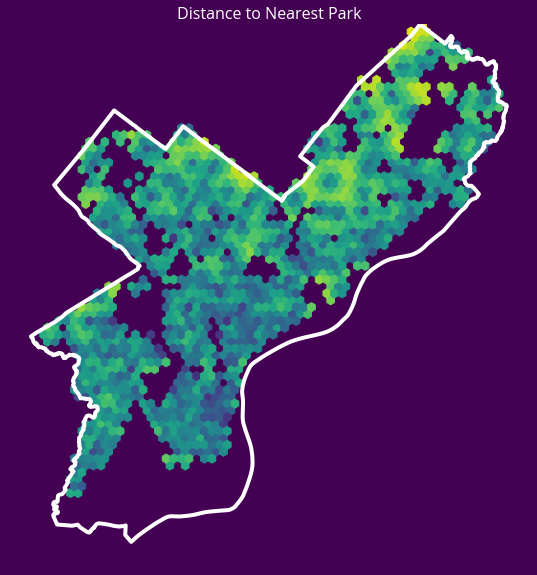

In [74]:
fig, ax = plt.subplots(figsize=(10,10), facecolor=plt.get_cmap('viridis')(0))

x = salesXY[:,0]
y = salesXY[:,1]
ax.hexbin(x, y, C=np.log10(parksDists.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to Nearest Park", fontsize=16, color='white');

### City Hall

New feature: Distance to City Hall.

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/city-landmarks)
* GeoService URL: https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/CITY_LANDMARKS/FeatureServer/0

**Notes**

- To identify City Hall, you'll need to pull data where "NAME='City Hall'" and "FEAT_TYPE='Municipal Building'"
- As with the parks, the geometry will be a *polygon*, so you should calculate the distance to the *centroid* of the City Hall polygon

In [75]:
# Get the data
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/CITY_LANDMARKS/FeatureServer/0"
cityHall = esri2gpd.get(url, where="NAME = 'City Hall' AND FEAT_TYPE = 'Municipal Building'")

# Get the X/Y
cityHallXY = get_xy_from_geometry(cityHall.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(cityHallXY)
cityHallDist, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales['logDistCityHall'] = np.log10(cityHallDist.mean(axis=1))

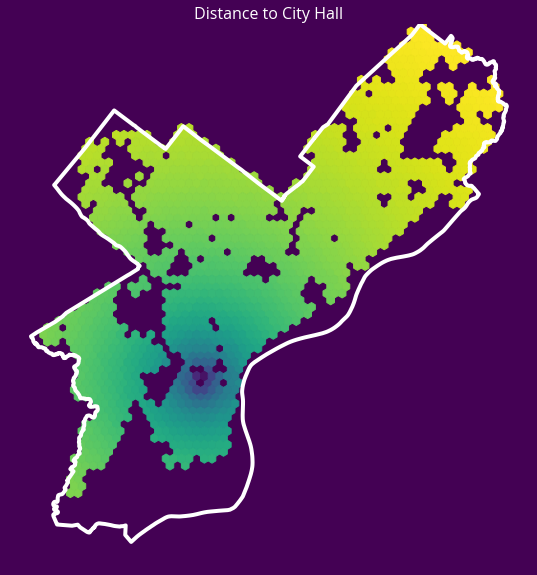

In [76]:
fig, ax = plt.subplots(figsize=(10,10), facecolor=plt.get_cmap('viridis')(0))

x = salesXY[:,0]
y = salesXY[:,1]
ax.hexbin(x, y, C=np.log10(cityHallDist.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to City Hall", fontsize=16, color='white');

### New Construction Permits

New feature: Distance to the 5 nearest new construction permits from 2018

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/licenses-and-inspections-building-permits)
* CARTO table name: "li_permits"

**Notes**

* You can pull new construction permits only by selecting where `permitdescription` equals 'NEW CONSTRUCTION PERMIT'
* You can select permits from only 2018 using the `permitissuedate` column

In [77]:
# Get the data
table_name = "li_permits"
where = "permitissuedate >= '2018-01-01' AND permitissuedate < '2019-01-01' AND permitdescription='NEW CONSTRUCTION PERMIT'"
permits = carto2gpd.get(carto_url, table_name, where=where)

# Get the X/Y
permitsXY = get_xy_from_geometry(permits.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(permitsXY)
permitsDist, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales['logDistPermits'] = np.log10(permitsDist.mean(axis=1))

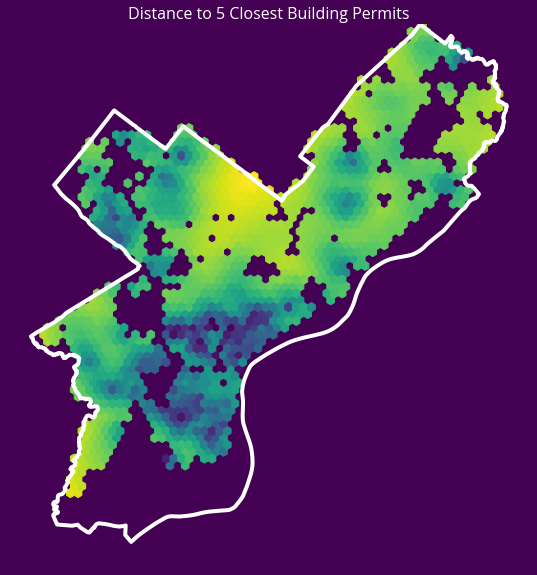

In [78]:
fig, ax = plt.subplots(figsize=(10,10), facecolor=plt.get_cmap('viridis')(0))

x = salesXY[:,0]
y = salesXY[:,1]
ax.hexbin(x, y, C=np.log10(permitsDist.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to 5 Closest Building Permits", fontsize=16, color='white');

### Aggravated Assaults

New feature: Distance to the 5 nearest aggravated assaults in 2018

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/crime-incidents)
* CARTO table name: "incidents_part1_part2"

**Notes**

* You can pull aggravated assaults only by selecting where `Text_General_Code` equals 'Aggravated Assault No Firearm' or 'Aggravated Assault Firearm'
* You can select crimes from only 2018 using the `dispatch_date` column

In [79]:
# Get the data
table_name = "incidents_part1_part2"

# Where selection
where = "dispatch_date >= '2018-01-01' AND dispatch_date < '2019-01-01' AND Text_General_Code IN ('Aggravated Assault No Firearm', 'Aggravated Assault Firearm')"

# Query
assaults = carto2gpd.get(carto_url, table_name, where=where)

# Remove missing 
assaults = assaults.loc[assaults.geometry.notnull()]
    
# Get the X/Y
assaultsXY = get_xy_from_geometry(assaults.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(assaultsXY)
assaultDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales['logDistAssaults'] = np.log10(assaultDists.mean(axis=1))

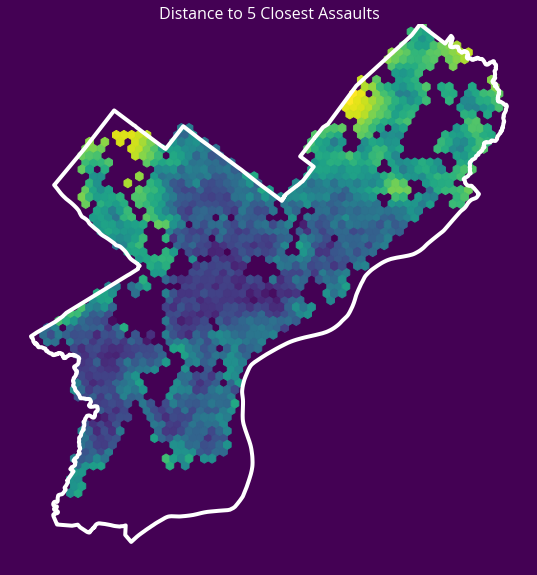

In [80]:
fig, ax = plt.subplots(figsize=(10,10), facecolor=plt.get_cmap('viridis')(0))

x = salesXY[:,0]
y = salesXY[:,1]
ax.hexbin(x, y, C=np.log10(assaultDists.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to 5 Closest Assaults", fontsize=16, color='white');

### Abandonded Vehicle 311 Calls

New feature: Distance to the 5 nearest abandoned vehicle 311 calls in 2018

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/311-service-and-information-requests)
* CARTO table name: "public_cases_fc"

**Notes**

* You can pull abandonded vehicle calls only by selecting where `service_name` equals 'Abandoned Vehicle'
* You can select crimes from only 2018 using the `requested_datetime` column

In [100]:
# Get the data
table_name = "public_cases_fc"

# Where selection
where = "requested_datetime >= '2018-01-01' AND requested_datetime < '2019-01-01' AND service_name = 'Abandoned Vehicle'"

# Query
cars = carto2gpd.get(carto_url, table_name, where=where)

# Remove missing 
cars = cars.loc[cars.geometry.notnull()]
    
# Get the X/Y
carsXY = get_xy_from_geometry(cars.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(carsXY)
carDists, _ = nbrs.kneighbors(salesXY)

# Handle any sales that have 0 distances
carDists[carDists == 0] = 1e-5 # a small, arbitrary value

# Add the new feature
sales['logDistCars'] = np.log10(carDists.mean(axis=1))

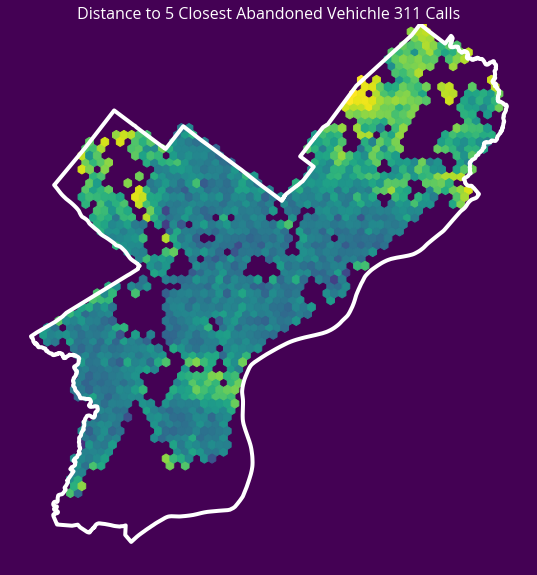

In [101]:
fig, ax = plt.subplots(figsize=(10,10), facecolor=plt.get_cmap('viridis')(0))

x = salesXY[:,0]
y = salesXY[:,1]
ax.hexbin(x, y, C=np.log10(carDists.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to 5 Closest Abandoned Vehichle 311 Calls", fontsize=16, color='white');

### Now, let's fit our updated model

In [102]:
# Numerical columns
num_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "logDistGraffiti", # NEW
    "logDistSubway", # NEW
    "logDistUniv", # NEW
    "logDistParks", # NEW
    "logDistCityHall", # NEW 
    "logDistPermits", # NEW
    "logDistAssaults", # NEW
    "logDistCars" # NEW
]

# Categorical columns
cat_cols = ["exterior_condition", "zip_code"]

In [103]:
# Set up the column transformer with two transformers
# Scale the numerical columns and one-hot 
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

In [104]:
# Two steps in pipeline: preprocessor and then regressor
regr = make_pipeline(
    preprocessor, RandomForestRegressor(n_estimators=20, random_state=42)
)

In [105]:
# Split the data 70/30
train_set, test_set = train_test_split(sales, test_size=0.3, random_state=42)

# the target labels
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

In [106]:
# Fit the training set
regr.fit(train_set, y_train);

In [107]:
# What's the test score?
regr.score(test_set, y_test)

0.736486682087392

## Small improvement!

In [108]:
plot_feature_importances(regr, num_cols, preprocessor, top=30, height=500)

:Bars   [Feature]   (Importance)

## Part 2: Predicting bikeshare demand in Philadelphia

**The technical problem**: predict bikeshare trip counts for the Indego bikeshare in Philadelphia



## The policy question: how to best expand a bikeshare program?

- Bikeshares typically require substantial capital when first launching, about \\$4,000 to \\$5,000 per bike
- Once launched, revenue from riders typically covers about 80 percent of operating costs
- Ridership peaks in busy downtown hubs, but how to best expand outwards, often to low-density and low-income communities?
- Important cost/benefit questions of how/where to expand to maximize ridership and access and minimize the need for outside subsidies

For more info, see [this blog post](https://www.pewtrusts.org/en/research-and-analysis/blogs/stateline/2016/03/24/despite-popularity-bike-share-programs-often-need-subsidies) from Pew

## Using predictive modeling as a policy tool

- Construct a predictive model for trip counts by stations in a bikeshare
- Use this model to estimate and map out the ridership for potential stations in new areas
- Use the cost per ride to estimate the additional revenue added
- Compare this additional revenue to the cost of adding new stations

## What are the key assumptions here?

**Most important:** adding new stations in new areas will not affect the demand for existing stations.

This allows the results from the predictive model for demand, built on existing stations, to translate to new stations. 

The key assumption is that the bikeshare is not yet at full capacity, and riders in new areas will not decrease the demand in other areas.

## Is this a good assumption?

- Given that the bikeshare is looking to expand, it's a safe bet that they believe the program is not yet at full capacity
- This is verifiable with existing data — examine trip counts in neighboring stations when a new station opens up. 

**Typically, this is a pretty safe assumption.** But I encourage you to use historical data to verify it!

**Two important columns:**

- `totalDocks`: the total number of docks at each station
- `kioskId`: the unique identifier for each station

## Getting trip data for the Indego bike share

- Available by quarter from: https://www.rideindego.com/about/data/
- I've pulled trip data for 2018 and 2019 (through Q3) and combined into a single CSV file (available in the data folder)

The data page also includes the live status of all of the stations in the system.

In [109]:
# Get the live station status
stations = gpd.read_file("http://www.rideindego.com/stations/json/")

In [110]:
stations.head()

addressStreet   addressCity addressState addressZipCode  \
0  1401 John F. Kennedy Blvd.  Philadelphia           PA          19102   
1              191 S. 2nd St.  Philadelphia           PA          19106   
2             246 S. 40th St.  Philadelphia           PA          19104   
3             328 S. 11th St.  Philadelphia           PA          19107   
4           1076 Berks Street  Philadelphia           PA          19122   

   bikesAvailable closeTime  docksAvailable eventEnd eventStart  isEventBased  \
0              18  03:55:00              12     None       None         False   
1               9  03:55:00               4     None       None         False   
2               3  03:55:00              14     None       None         False   
3               9  03:55:00              11     None       None         False   
4              11  03:55:00               8     None       None         False   

   isVirtual  isVisible  kioskId kioskPublicStatus  kioskStatus  \
0      False      False     3004            Active  FullService   
1      False      False     3005            Active  FullService   
2      False      False     3006            Active  FullService   
3      False      False     3007            Active  FullService   
4      False      False     3008            Active  FullService   

                                name notes  openTime publicText  \
0  Municipal Services Building Plaza  None  04:00:00              
1                  Welcome Park, NPS  None  04:00:00              
2                      40th & Spruce  None  04:00:00              
3             11th & Pine, Kahn Park  None  04:00:00              
4          Temple University Station  None  04:00:00              

                timeZone  totalDocks  trikesAvailable kioskConnectionStatus  \
0  Eastern Standard Time          30                0                Active   
1  Eastern Standard Time          13                0                Active   
2  Eastern Standard Time          17                0                Active   
3  Eastern Standard Time          20                0                Active   
4  Eastern Standard Time          19                0                Active   

   kioskType  latitude  longitude  hasGeofence  classicBikesAvailable  \
0          1  39.95378  -75.16374        False                     18   
1          1  39.94733  -75.14403        False                      8   
2          1  39.95220  -75.20311        False                      3   
3          1  39.94517  -75.15993        False                      9   
4          1  39.98078  -75.15055        False                     11   

   smartBikesAvailable  electricBikesAvailable  isArchived  \
0                    0                       0       False   
1                    0                       1       False   
2                    0                       0       False   
3                    0                       0       False   
4                    0                       0       False   

   potentialDocksAvailable                    geometry  
0                      NaN  POINT (-75.16374 39.95378)  
1                      NaN  POINT (-75.14403 39.94733)  
2                      NaN  POINT (-75.20311 39.95220)  
3                      NaN  POINT (-75.15993 39.94517)  
4                      NaN  POINT (-75.15055 39.98078)

## Let's plot the stations, colored by the number of docks

In [111]:
import contextily as ctx

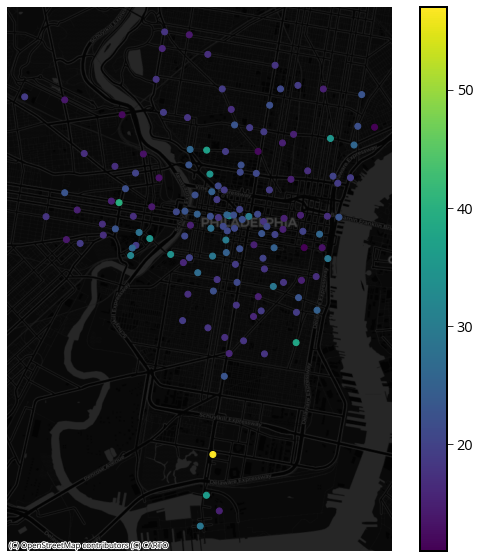

In [112]:
fig, ax = plt.subplots(figsize=(10,10))

# stations
stations_3857 = stations.to_crs(epsg=3857)
stations_3857.plot(ax=ax, column='totalDocks', legend=True)

# plot the basemap underneath
ctx.add_basemap(ax=ax, crs=stations_3857.crs, url=ctx.providers.CartoDB.DarkMatter)

ax.set_axis_off()

## Load all trips from 2018 and 2019

In [113]:
all_trips = pd.read_csv("./data/indego-trips-2018-2019.csv.tar.gz")

/Users/nhand/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [114]:
all_trips.head()

Unnamed: 0    trip_id  duration           start_time             end_time  \
0           0  223869188        18  2018-01-01 00:24:00  2018-01-01 00:42:00   
1           1  223905597       572  2018-01-01 00:38:00  2018-01-01 10:10:00   
2           2  223872811        22  2018-01-01 00:48:00  2018-01-01 01:10:00   
3           3  223872810        21  2018-01-01 01:03:00  2018-01-01 01:24:00   
4           4  223872809         4  2018-01-01 01:05:00  2018-01-01 01:09:00   

   start_station  start_lat  start_lon  end_station    end_lat    end_lon  \
0           3124  39.952950 -75.139793         3073  39.961430 -75.152420   
1           3023  39.950481 -75.172859         3066  39.945610 -75.173477   
2           3026  39.941380 -75.145638         3023  39.950481 -75.172859   
3           3045  39.947922 -75.162369         3037  39.954239 -75.161377   
4           3115  39.972630 -75.167572         3058  39.967159 -75.170013   

  bike_id  plan_duration trip_route_category passholder_type  
0    3708           30.0             One Way        Indego30  
1    3288          365.0             One Way       Indego365  
2   11735           30.0             One Way        Indego30  
3    5202           30.0             One Way        Indego30  
4    5142           30.0             One Way        Indego30

## Dependent variable: total trips by starting station

In [115]:
start_trips = all_trips.groupby("start_station").size().reset_index(name="total_start_trips")

In [116]:
start_trips

start_station  total_start_trips
0             3000                425
1             3004              12622
2             3005               7449
3             3006               7831
4             3007              17947
..             ...                ...
143           3209                209
144           3210                529
145          90007                 15
146          90010                  1
147          90018                  2

[148 rows x 2 columns]

In [117]:
# Now merge in the geometry for each station
bike_data = (
    stations[["geometry", "kioskId"]]
    .merge(start_trips, left_on="kioskId", right_on="start_station")
    .to_crs(epsg=3857)
)

Let's plot it...

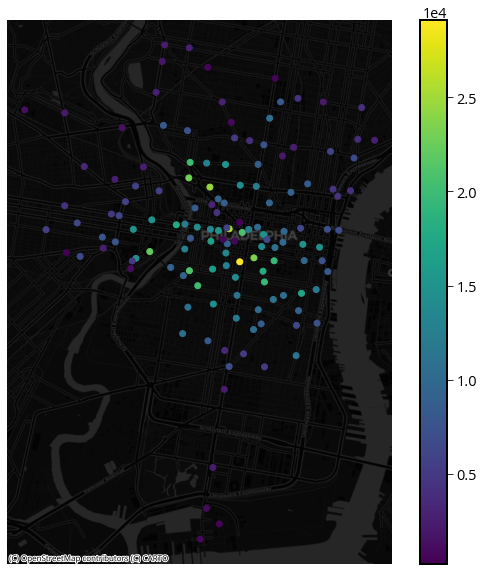

In [118]:
fig, ax = plt.subplots(figsize=(10,10))

# stations
bike_data.plot(ax=ax, column='total_start_trips', legend=True)

# plot the basemap underneath
ctx.add_basemap(ax=ax, crs=bike_data.crs, url=ctx.providers.CartoDB.DarkMatter)

ax.set_axis_off()

Trips are clearly concentrated in Center City...

## What features to use?

There are lots of possible options. Generally speaking, the possible features fall into a few different categories:

- **Internal**
    - e.g., the number of docks per station
- **Demographic (Census)**    
    - e.g., population, income, percent commuting by car, percent with bachelor's degree or higher, etc
- **Amenities/Disamenities**
    - e.g., distance to nearest crimes, restaurants, parks, within Center City Business District, etc
- **Transportation network**
    - e.g., distance to nearest bus stop, interesection nodes, nearest subway stop
- **Neighboring stations**
    - e.g., average trips of nearest stations, distance to nearest stations
    
**Let's add a few from each category...**

## 1. Internal characteristics

Let's use the number of docks per stations:

In [119]:
bike_data = bike_data.merge(stations[["kioskId", "totalDocks"]], on="kioskId")
bike_data.head()

geometry  kioskId  start_station  \
0  POINT (-8367189.263 4859227.987)     3004           3004   
1  POINT (-8364995.156 4858291.368)     3005           3005   
2  POINT (-8371571.911 4858998.543)     3006           3006   
3  POINT (-8366765.136 4857977.729)     3007           3007   
4  POINT (-8365720.959 4863149.674)     3008           3008   

   total_start_trips  totalDocks  
0              12622          30  
1               7449          13  
2               7831          17  
3              17947          20  
4               4377          19

## 2. Census demographic data

We'll try out percent commuting by car first.

In [120]:
from census import Census

In [121]:
# Note that using an API key of "None" should work for most use cases
c = Census(key=None)

In [122]:
# Variable names chosen from: https://api.census.gov/data/2017/acs/acs5/variables.html
# This is the total number of commuters and those commuting by car
variables = ("NAME", "B08134_001E", "B08134_011E")
census_data = pd.DataFrame(c.acs5.state_county_tract(variables, "42", "101", "*"))

# The percent commuting by car
census_data["percent_car"] = census_data["B08134_011E"] / census_data["B08134_001E"]

In [123]:
census_data.head()

NAME  B08134_001E  \
0  Census Tract 244, Philadelphia County, Pennsyl...        861.0   
1  Census Tract 359, Philadelphia County, Pennsyl...       2518.0   
2  Census Tract 362.01, Philadelphia County, Penn...       2414.0   
3  Census Tract 362.02, Philadelphia County, Penn...       2840.0   
4  Census Tract 106, Philadelphia County, Pennsyl...        395.0   

   B08134_011E state county   tract  percent_car  
0        618.0    42    101  024400     0.717770  
1       2339.0    42    101  035900     0.928912  
2       2228.0    42    101  036201     0.922949  
3       2396.0    42    101  036202     0.843662  
4        153.0    42    101  010600     0.387342

Merge with census tract geometries for Philadelphia:

In [124]:
import us

In [125]:
pa_tracts = gpd.read_file(us.states.PA.shapefile_urls('tract'))

In [126]:
census_data = pa_tracts.merge(
    census_data,
    left_on=["STATEFP10", "COUNTYFP10", "TRACTCE10"],
    right_on=["state", "county", "tract"],
)


Finally, let's merge the census data into our dataframe of features by spatially joining the stations and the census tracts:

In [127]:
census_data.head()

STATEFP10 COUNTYFP10 TRACTCE10      GEOID10  NAME10           NAMELSAD10  \
0        42        101    036301  42101036301  363.01  Census Tract 363.01   
1        42        101    036400  42101036400     364     Census Tract 364   
2        42        101    036600  42101036600     366     Census Tract 366   
3        42        101    034803  42101034803  348.03  Census Tract 348.03   
4        42        101    034702  42101034702  347.02  Census Tract 347.02   

  MTFCC10 FUNCSTAT10  ALAND10  AWATER10   INTPTLAT10    INTPTLON10  \
0   G5020          S  2322732     66075  +40.0895349  -074.9667387   
1   G5020          S  4501110      8014  +40.1127747  -074.9789137   
2   G5020          S  1004313   1426278  +39.9470272  -075.1404472   
3   G5020          S  1271533      8021  +40.0619427  -075.0023705   
4   G5020          S  1016206         0  +40.0570427  -075.0283288   

                                            geometry  \
0  POLYGON ((-74.96188 40.09781, -74.96163 40.097...   
1  POLYGON ((-74.97780 40.10710, -74.97896 40.106...   
2  POLYGON ((-75.14147 39.95170, -75.14145 39.952...   
3  POLYGON ((-75.00887 40.05865, -75.00915 40.059...   
4  POLYGON ((-75.02543 40.06565, -75.02533 40.065...   

                                                NAME  B08134_001E  \
0  Census Tract 363.01, Philadelphia County, Penn...       1949.0   
1  Census Tract 364, Philadelphia County, Pennsyl...        217.0   
2  Census Tract 366, Philadelphia County, Pennsyl...       1392.0   
3  Census Tract 348.03, Philadelphia County, Penn...       1933.0   
4  Census Tract 347.02, Philadelphia County, Penn...       1908.0   

   B08134_011E state county   tract  percent_car  
0       1728.0    42    101  036301     0.886609  
1        156.0    42    101  036400     0.718894  
2        887.0    42    101  036600     0.637213  
3       1735.0    42    101  034803     0.897569  
4       1615.0    42    101  034702     0.846436

In [128]:
bike_data = gpd.sjoin(
    bike_data,
    census_data.to_crs(bike_data.crs)[["geometry", "percent_car"]],
    op="within",
).drop(labels=['index_right'], axis=1)

In [129]:
bike_data.head()

geometry  kioskId  start_station  \
0    POINT (-8367189.263 4859227.987)     3004           3004   
17   POINT (-8367777.030 4859245.413)     3021           3021   
68   POINT (-8368099.856 4859194.586)     3078           3078   
82   POINT (-8367386.298 4859137.951)     3108           3108   
129  POINT (-8367847.161 4859274.457)     3195           3195   

     total_start_trips  totalDocks  percent_car  
0                12622          30     0.385135  
17               25805          34     0.385135  
68               15099          18     0.385135  
82               20847          22     0.385135  
129               6083          26     0.385135

"Impute" missing values with the median value:

In [130]:
missing = bike_data['percent_car'].isnull()
bike_data.loc[missing, 'percent_car'] = bike_data['percent_car'].median()

## Amenities/disamenities

Let's add two new features:

1. Distances to the nearest 10 restaurants from Open Street Map
1. Whether the station is within the Center City Business District

### Restaurants

Search https://wiki.openstreetmap.org/wiki/Map_Features for OSM identifier of restaurants

In [131]:
restaurants = osm2gpd.get(lng_min, lat_min, lng_max, lat_max, where="amenity=restaurant").to_crs(epsg=3857)
restaurants.head()

lat        lon     amenity       brand brand:wikidata  \
id                                                                       
274216909  39.955306 -75.198587  restaurant     Chili's       Q1072948   
274217382  39.953342 -75.193493  restaurant         NaN            NaN   
332503202  39.944961 -74.958534  restaurant  Friendly's       Q1464513   
333786044  39.940858 -75.158928  restaurant         NaN            NaN   
333786448  39.942642 -75.157958  restaurant         NaN            NaN   

          brand:wikipedia   cuisine                 name        official_name  \
id                                                                              
274216909      en:Chili's   tex-mex              Chili's  Chili's Grill & Bar   
274217382             NaN   mexican              Mad4Mex                  NaN   
332503202   en:Friendly's  american           Friendly's                  NaN   
333786044             NaN       NaN  Sam's Morning Glory                  NaN   
333786448             NaN       NaN               Supper                  NaN   

              addr:city addr:housenumber addr:postcode    addr:street  \
id                                                                      
274216909           NaN              NaN           NaN            NaN   
274217382  Philadelphia             3401         19104  Walnut Street   
332503202           NaN              NaN           NaN            NaN   
333786044           NaN              NaN           NaN            NaN   
333786448           NaN              NaN           NaN            NaN   

                               email           fax  \
id                                                   
274216909                        NaN           NaN   
274217382  universitycity@madmex.com  215-382-2225   
332503202                        NaN           NaN   
333786044                        NaN           NaN   
333786448                        NaN           NaN   

                           opening_hours         phone  \
id                                                       
274216909                            NaN           NaN   
274217382  Mo-Su 00:00-02:00,11:30-24:00  215-382-2221   
332503202                            NaN           NaN   
333786044                            NaN           NaN   
333786448                            NaN           NaN   

                                                     website wheelchair  \
id                                                                        
274216909                                                NaN        NaN   
274217382  http://madmex.com/philadelphia/university-city...        NaN   
332503202                                                NaN        NaN   
333786044                                                NaN    limited   
333786448                                                NaN        NaN   

          addr:state description outdoor_seating diet:vegetarian  \
id                                                                 
274216909        NaN         NaN             NaN             NaN   
274217382        NaN         NaN             NaN             NaN   
332503202        NaN         NaN             NaN             NaN   
333786044        NaN         NaN             NaN             NaN   
333786448        NaN         NaN             NaN             NaN   

          addr:housename designation diet:vegan delivery  bar takeaway  \
id                                                                       
274216909            NaN         NaN        NaN      NaN  NaN      NaN   
274217382            NaN         NaN        NaN      NaN  NaN      NaN   
332503202            NaN         NaN        NaN      NaN  NaN      NaN   
333786044            NaN         NaN        NaN      NaN  NaN      NaN   
333786448            NaN         NaN        NaN      NaN  NaN      NaN   

          smoking alt_name short_name twitter drive_in internet_access  \
id                                  

Get x/y values for the stations:

In [132]:
stationsXY = get_xy_from_geometry(bike_data)

In [133]:
# STEP 1: x/y coordinates of restaurants (in EPGS=3857)
restsXY = get_xy_from_geometry(restaurants.to_crs(epsg=3857))

# STEP 2: Initialize the algorithm
nbrs = NearestNeighbors(n_neighbors=5)

# STEP 3: Fit the algorithm on the "neighbors" dataset
nbrs.fit(restsXY)

# STEP 4: Get distances for stations to neighbors
restsDists, restsIndices = nbrs.kneighbors(stationsXY)

# STEP 5: add back to the original dataset
bike_data['logDistRests'] = np.log10(restsDists.mean(axis=1))

In [134]:
bike_data.head()

geometry  kioskId  start_station  \
0    POINT (-8367189.263 4859227.987)     3004           3004   
17   POINT (-8367777.030 4859245.413)     3021           3021   
68   POINT (-8368099.856 4859194.586)     3078           3078   
82   POINT (-8367386.298 4859137.951)     3108           3108   
129  POINT (-8367847.161 4859274.457)     3195           3195   

     total_start_trips  totalDocks  percent_car  logDistRests  
0                12622          30     0.385135      2.584254  
17               25805          34     0.385135      2.464111  
68               15099          18     0.385135      2.383822  
82               20847          22     0.385135      2.597702  
129               6083          26     0.385135      2.467754

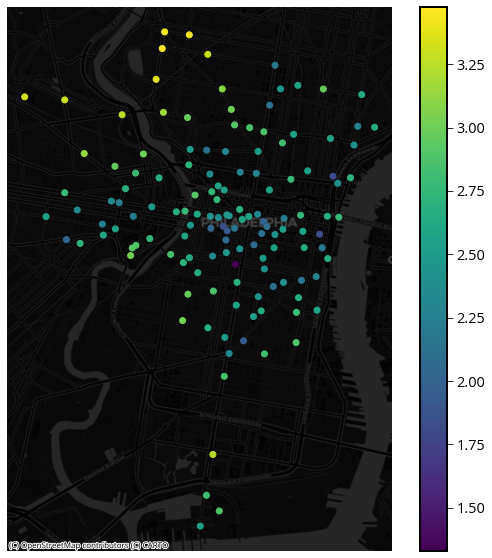

In [135]:
fig, ax = plt.subplots(figsize=(10,10))

# stations
bike_data.plot(ax=ax, column='logDistRests', legend=True)

# plot the basemap underneath
ctx.add_basemap(ax=ax, crs=bike_data.crs, url=ctx.providers.CartoDB.DarkMatter)

ax.set_axis_off()

### Center City Business District

Available from [OpenDataPhilly](https://www.opendataphilly.org/dataset/center-city-business-improvement-district)

In [136]:
url = "http://data.phl.opendata.arcgis.com/datasets/95366b115d93443eae4cc6f498cb3ca3_0.geojson"
cc_bid = gpd.read_file(url).to_crs(epsg=3857)

In [137]:
cc_bid

OBJECTID                  NAME  SHAPE_STAREA__  SHAPE_STLENGTH__  \
0         1  Center City District    2.431219e+07      35937.365683   

                                            geometry  
0  POLYGON ((-8366831.214 4860266.872, -8366832.5...

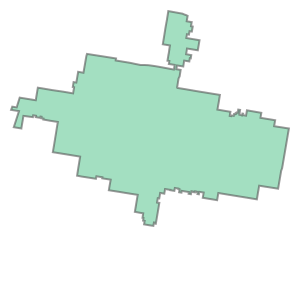

In [138]:
cc_bid_geo = cc_bid.iloc[0].geometry

cc_bid_geo

In [139]:
bike_data['within_cc_bid'] = bike_data.geometry.within(cc_bid_geo).astype(int)

In [140]:
bike_data.head()

geometry  kioskId  start_station  \
0    POINT (-8367189.263 4859227.987)     3004           3004   
17   POINT (-8367777.030 4859245.413)     3021           3021   
68   POINT (-8368099.856 4859194.586)     3078           3078   
82   POINT (-8367386.298 4859137.951)     3108           3108   
129  POINT (-8367847.161 4859274.457)     3195           3195   

     total_start_trips  totalDocks  percent_car  logDistRests  within_cc_bid  
0                12622          30     0.385135      2.584254              1  
17               25805          34     0.385135      2.464111              1  
68               15099          18     0.385135      2.383822              1  
82               20847          22     0.385135      2.597702              1  
129               6083          26     0.385135      2.467754              1

### Transportation Network

- Let's add a feature that calculates the distance to the nearest intersections
- We can use the osmnx package

In [141]:
import osmnx as ox

In [142]:
xmin, ymin, xmax, ymax = bike_data.to_crs(epsg=4326).total_bounds

In [143]:
ox.graph_from_bbox?

Create the graph object from the bounding box:

In [144]:
G = ox.graph_from_bbox(ymax, ymin, xmax, xmin)

G

Let's plot the graph using the built-in plotting from osmnx:

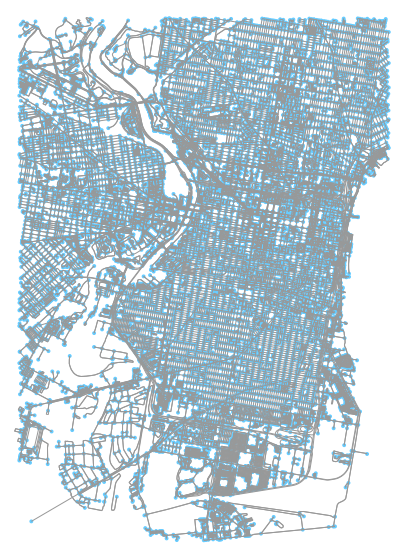

In [145]:
ox.plot_graph(G, fig_height=10);

Now extract the nodes (intersections) from the graph into a GeoDataFrame:

In [146]:
interesections = ox.graph_to_gdfs(G, nodes=True, edges=False).to_crs(epsg=3857)

In [147]:
interesections.head()

y          x       osmid          highway  ref  \
109903872   39.919692 -75.188374   109903872  traffic_signals  NaN   
110559239   39.984073 -75.145184   110559239              NaN  NaN   
110297098   39.941732 -75.173522   110297098              NaN  NaN   
5708709908  39.980197 -75.157375  5708709908              NaN  NaN   
5708709909  39.980238 -75.157698  5708709909              NaN  NaN   

                                    geometry  
109903872   POINT (-8369931.485 4854278.964)  
110559239   POINT (-8365123.618 4863628.081)  
110297098   POINT (-8368278.168 4857478.469)  
5708709908  POINT (-8366480.714 4863064.921)  
5708709909  POINT (-8366516.648 4863070.949)

Now, compute the average distance to the 10 nearest intersections:

In [148]:
# STEP 1: x/y coordinates of restaurants (in EPGS=3857)
intersectionsXY = get_xy_from_geometry(interesections.to_crs(epsg=3857))

# STEP 2: Initialize the algorithm
nbrs = NearestNeighbors(n_neighbors=10)

# STEP 3: Fit the algorithm on the "neighbors" dataset
nbrs.fit(intersectionsXY)

# STEP 4: Get distances for stations to neighbors
interDists, interIndices = nbrs.kneighbors(stationsXY)

# STEP 5: add back to the original dataset
bike_data['logIntersectionDists'] = np.log10(interDists.mean(axis=1))

Let's plot the stations, coloring by the new feature (distance to intersections):

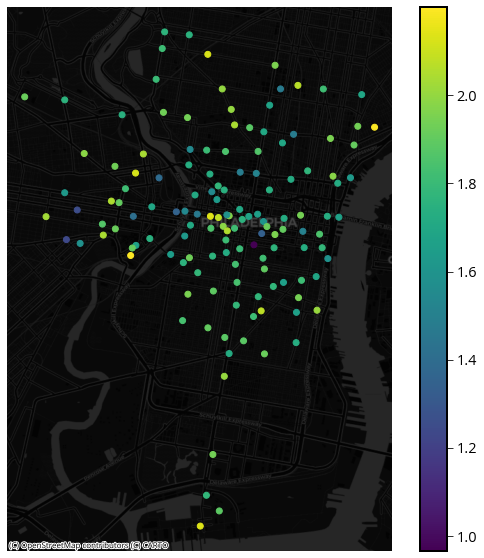

In [149]:
fig, ax = plt.subplots(figsize=(10,10))

# stations
bike_data.plot(ax=ax, column='logIntersectionDists', legend=True)

# plot the basemap underneath
ctx.add_basemap(ax=ax, crs=bike_data.crs, url=ctx.providers.CartoDB.DarkMatter)

ax.set_axis_off()

### Neighboring Stations

- We need to include features that encodes the fact that demand for a specific station is likely related to the demand in neighboring stations
- This idea is known as **spatial lag**

We will add two new features:

1. The average distance to the nearest 5 stations
1. The average trip total for the nearest 5 stations

First, find the nearest 5 stations:

In [150]:
k = 6
nbrs = NearestNeighbors(n_neighbors=k)
nbrs.fit(stationsXY)

stationDists, stationIndices = nbrs.kneighbors(stationsXY)

**Notes**

- We are matching the stations to themselves to find the nearest neighbors
- The closest match will always be the same station (distance of 0)
- So we fit for $k+1$ neighbors and will remove the closest neighbor

The log of the distances to the 5 nearest stations:

In [151]:
bike_data['logStationDists'] = np.log10(stationDists[:,1:].mean(axis=1))

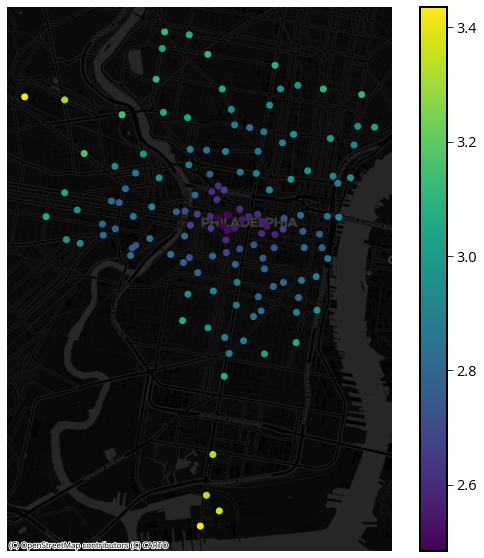

In [152]:
fig, ax = plt.subplots(figsize=(10,10))

# stations
bike_data.plot(ax=ax, column='logStationDists', legend=True)

# plot the basemap underneath
ctx.add_basemap(ax=ax, crs=bike_data.crs, url=ctx.providers.CartoDB.DarkMatter)

ax.set_axis_off()

Now, let's add the trip counts of the 5 neighboring stations:

**Use the indices returned by the NearestNeighbors() algorithm to identify which stations are the 5 neighbors in the original data**

In [153]:
stationIndices[:, 1:]

array([[  3,  60,  30,  33,   5],
       [  4,   2,   6,  30,   5],
       [ 84,   4,   6,   1,  86],
       [  0,  30,   5,   1,   4],
       [  1,   2,   6,  30,   5],
       [ 87,   6,   3,   1, 134],
       [ 87,   2,   5,   4,   1],
       [ 73,  38,   8,  39,   9],
       [ 39,   7,  38,  73,  35],
       [ 51,  73,  94,   7,   8],
       [ 12,  13,  11, 126, 101],
       [126,  23,  10,  43,  13],
       [ 10,  13,  48,  45,  47],
       [ 12,  10,  43,  45,  44],
       [108,  77,  72, 129,  19],
       [ 16,  32, 137,  79,  90],
       [ 15,  79, 137,  32,  62],
       [ 43,  42,  18,  41,  23],
       [ 58,  59,  17,  66,  23],
       [ 20,  72,  22, 134,   5],
       [134,  19,  21,  22,  87],
       [ 20, 134,  24,  54,  22],
       [ 20,  19,  25,  21, 134],
       [126,  58,  11,  91,  43],
       [ 54,  56,  21,  89,  88],
       [ 22,  92,  88,  50, 108],
       [ 99,  96,  95,  31,  90],
       [ 68,  29,  67,  28,  65],
       [ 27,  46,  83,  29,  68],
       [ 27,  

In [154]:
# the total trips for the stations from original data frame
total_start_trips = bike_data['total_start_trips'].values

In [155]:
# get the trips for the 5 nearest neighbors (ignoring first match)
neighboring_trips = total_start_trips[stationIndices[:,1:]]

In [156]:
neighboring_trips

array([[20847,  9867,   406, 14963,   758],
       [ 6083, 15099,   683,   406,   758],
       [13846,  6083,   683, 25805, 16719],
       [12622,   406,   758, 25805,  6083],
       [25805, 15099,   683,   406,   758],
       [ 9270,   683, 20847, 25805, 13367],
       [ 9270, 15099,   758,  6083, 25805],
       [ 8033, 14652,  9830, 14717, 11997],
       [14717,  7449, 14652,  8033, 10115],
       [17142,  8033,  8849,  7449,  9830],
       [ 2658,  7687,  4882,  6180,  6372],
       [ 6180,  5676,  7831, 14680,  7687],
       [ 7831,  7687,  6543,  5253,  1097],
       [ 2658,  7831, 14680,  5253, 14479],
       [19528, 19513, 23572, 13998, 29104],
       [ 8252,  2203,   529, 10869,  2568],
       [ 4377, 10869,   529,  2203,  7564],
       [14680, 17904,  5667, 22043,  5676],
       [ 5874,  2605, 14967, 22936,  5676],
       [12885, 23572, 13793, 13367,   758],
       [13367, 29104, 16189, 13793,  9270],
       [12885, 13367, 20115, 21003, 13793],
       [12885, 29104, 11213, 161

In [157]:

# add to features
bike_data['laggedTrips'] = neighboring_trips.mean(axis=1)

## Is there a correlation between trip counts and the spatial lag?

Yes!

We can use seaborn to make a quick plot:

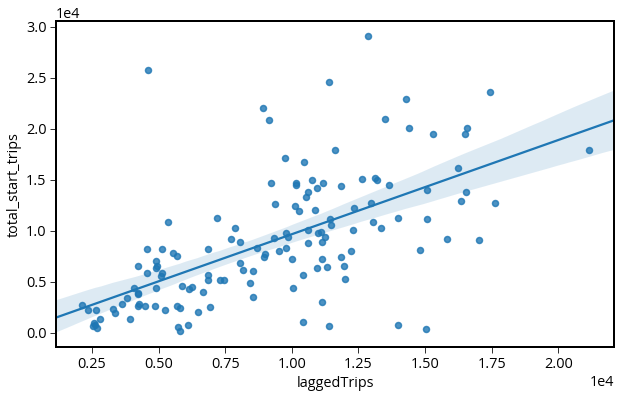

In [158]:
sns.regplot(bike_data['laggedTrips'], bike_data['total_start_trips'])

## Let's look at the correlations of all of our features

Again, use seaborn to investigate.

**Remember:** we don't want to include multipl features that are highly correlated in our model.

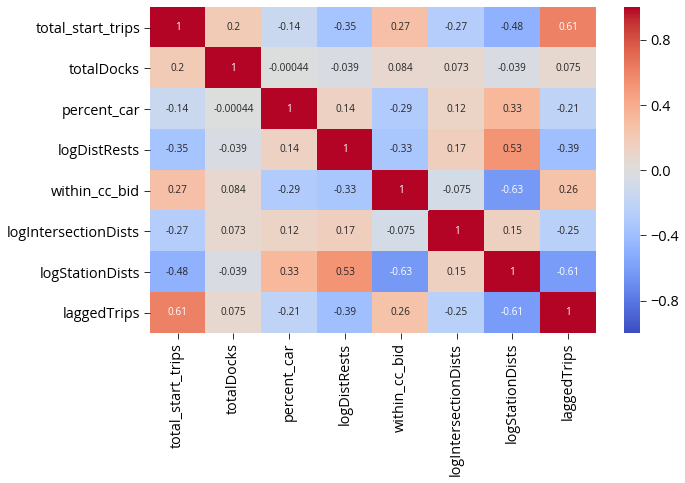

In [159]:
feature_cols = [
 'total_start_trips',
 'totalDocks',
 'percent_car',
 'logDistRests',
 'within_cc_bid',
 'logIntersectionDists',
 'logStationDists',
 'laggedTrips']
sns.heatmap(bike_data[feature_cols].corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1);

## Let's fit a model!

Just as before, the plan is to:
- Fit a random forest model, using cross validation to optimize (some) hyperparameters
- Compare to a baseline linear regression model

In [160]:
bike_data.head()

geometry  kioskId  start_station  \
0    POINT (-8367189.263 4859227.987)     3004           3004   
17   POINT (-8367777.030 4859245.413)     3021           3021   
68   POINT (-8368099.856 4859194.586)     3078           3078   
82   POINT (-8367386.298 4859137.951)     3108           3108   
129  POINT (-8367847.161 4859274.457)     3195           3195   

     total_start_trips  totalDocks  percent_car  logDistRests  within_cc_bid  \
0                12622          30     0.385135      2.584254              1   
17               25805          34     0.385135      2.464111              1   
68               15099          18     0.385135      2.383822              1   
82               20847          22     0.385135      2.597702              1   
129               6083          26     0.385135      2.467754              1   

     logIntersectionDists  logStationDists  laggedTrips  
0                1.683537         2.569087       9368.2  
17               1.971991         2.487815       4605.8  
68               2.083035         2.484441      12627.2  
82               1.755510         2.547388       9134.8  
129              1.584409         2.499836       8550.2

## Perform our test/train split

We'll use a 60%/40% split

In [161]:
# Remove unnecessary columns
bike_features = bike_data.drop(labels=["geometry", "kioskId", "start_station"], axis=1)

In [162]:
# Split the data 60/40
train_set, test_set = train_test_split(
    bike_features,
    test_size=0.4,
    random_state=42,
)

# the target labels
y_train = np.log(train_set["total_start_trips"])
y_test = np.log(test_set["total_start_trips"])

In [163]:
# Extract out only the features we want to use

feature_cols = [
 'totalDocks',
 'percent_car',
 'logDistRests',
 'within_cc_bid',
 'logIntersectionDists',
 'logStationDists',
 'laggedTrips']

train_set = train_set[feature_cols]
test_set = test_set[feature_cols]

## Random forest results

Let's run a simple grid search to try to optimize our hyperparameters.

In [164]:
# Setup the pipeline with a standard scaler
regr = make_pipeline(
    StandardScaler(), RandomForestRegressor(random_state=42)
)

In [165]:
model_name = "randomforestregressor"
param_grid = {
    f"{model_name}__n_estimators": [5, 10, 15, 20, 30, 50, 100, 200],
    f"{model_name}__max_depth": [2, 5, 7, 9, 13, 21, 33, 51, 100],
}

param_grid

{'randomforestregressor__n_estimators': [5, 10, 15, 20, 30, 50, 100, 200],
 'randomforestregressor__max_depth': [2, 5, 7, 9, 13, 21, 33, 51, 100]}

**Important:** just like last week, we will need to prefix the parameter name with the name of the pipeline step, in this case, "randomforestregressor".

In [166]:
# Create the grid and use 3-fold CV
grid = GridSearchCV(regr, param_grid, cv=3)

# Run the search
grid.fit(train_set.values, y_train);

/Users/nhand/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Evaluate the best estimator on the test set:

In [167]:
# Evaluate the best random forest model
best_random = grid.best_estimator_
best_random.score(test_set, y_test)

0.2797161882043818

## Evaluate a linear model (baseline) on the test set

In [168]:
# Set up a  linear pipeline
linear = make_pipeline(StandardScaler(), LinearRegression())

# Fit on train set
linear.fit(train_set, y_train)

# Evaluate on test set
linear.score(test_set, y_test)

0.07261565355301425

## Which features were the most important?

From our earlier correlation analysis, we should expect the most important features to be:
- the spatially lagged trip counts
- the distance to the nearest stations

In [169]:
# The best model
regressor = grid.best_estimator_["randomforestregressor"]

# Create the dataframe with importances
importance = pd.DataFrame(
    {"Feature": train_set.columns, "Importance": regressor.feature_importances_}
)

# Sort importance in descending order and get the top
importance = importance.sort_values("Importance", ascending=False).iloc[:50]

# Plot
importance.hvplot.barh(x="Feature", y="Importance", flip_yaxis=True, height=500)

:Bars   [Feature]   (Importance)

In [170]:
importance

Feature  Importance
6           laggedTrips    0.339581
5       logStationDists    0.305125
2          logDistRests    0.113524
0            totalDocks    0.104053
4  logIntersectionDists    0.086113
1           percent_car    0.042894
3         within_cc_bid    0.008710

## Let's analyze the spatial structure of the predictions visually

We'll plot the predicted and actual trip values

Use the test set index (`test_set.index`) to get the data from the original data frame (`bike_data`).

This will ensure we will have `geometry` info (not used in the modeling) for our test data set:

In [171]:
test_set.index

Int64Index([ 87,  72, 100,   9,  34,  51,  45,  90,  77,  40,  53,  98,  42,
             89,  12,  18,  10,   6, 116, 118,  78, 129,  81, 123,  71, 131,
             26,  62,   2, 106,  23,  22, 111,  43,  49, 127, 121,   0, 108,
             65, 117,   8,  31, 105,  60,  32,   4,  92,  39,  97, 110, 115,
             75, 122, 133,  50],
           dtype='int64')

In [172]:
# Extract the test data from the original dataset
# This will include the geometry data
X = bike_data.loc[test_set.index]

In [173]:
# test data extracted from our original data frame
X.head()

geometry  kioskId  start_station  \
87   POINT (-8369012.676 4856900.398)     3114           3114   
72   POINT (-8368971.488 4864662.117)     3096           3096   
100  POINT (-8371544.081 4858668.909)     3152           3152   
9    POINT (-8365428.189 4860591.687)     3013           3013   
34   POINT (-8367447.524 4860551.020)     3040           3040   

     total_start_trips  totalDocks  percent_car  logDistRests  within_cc_bid  \
87               11120          17     0.447323      2.975134              0   
72                2777          14     0.532483      3.436767              0   
100               2658          17     0.081109      2.610402              0   
9                 8241          17     0.509091      2.565116              0   
34               14155          21     0.462162      2.295498              0   

     logIntersectionDists  logStationDists  laggedTrips  
87               1.949125         2.937430      15077.0  
72               1.752702         3.079935       2110.8  
100              2.044148         2.837833       5682.2  
9                1.773588         2.964495       4576.8  
34               1.485074         2.851987      10962.2

In [174]:
test_set.head()

totalDocks  percent_car  logDistRests  within_cc_bid  \
87           17     0.447323      2.975134              0   
72           14     0.532483      3.436767              0   
100          17     0.081109      2.610402              0   
9            17     0.509091      2.565116              0   
34           21     0.462162      2.295498              0   

     logIntersectionDists  logStationDists  laggedTrips  
87               1.949125         2.937430      15077.0  
72               1.752702         3.079935       2110.8  
100              2.044148         2.837833       5682.2  
9                1.773588         2.964495       4576.8  
34               1.485074         2.851987      10962.2

 #### The data frame indices lines up!

Now, make our predictions, and convert them from log to raw counts:

In [175]:
# Predictions for log of total trip counts
log_predictions = grid.best_estimator_.predict(test_set)

# Convert the predicted test values from log
X['prediction'] = np.exp(log_predictions)

Let's make the plot with side-by-side panels for actual and predicted:

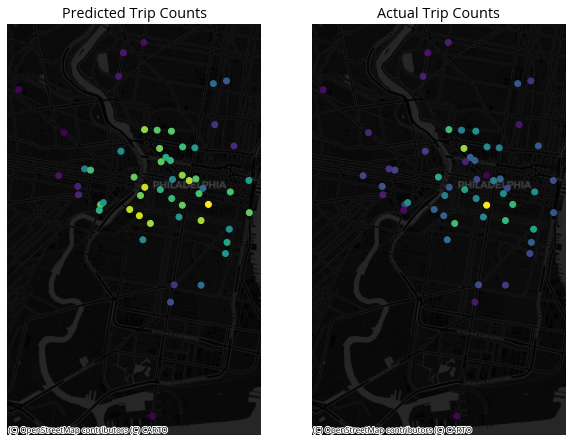

In [176]:
# Plot two columns
fig, axs = plt.subplots(ncols=2, figsize=(10,10))

# Predicted values
X.plot(ax=axs[0], column='prediction')
ctx.add_basemap(ax=axs[0], crs=X.crs, url=ctx.providers.CartoDB.DarkMatter)
axs[0].set_title("Predicted Trip Counts")

# Actual values
X.plot(ax=axs[1], column='total_start_trips')
ctx.add_basemap(ax=axs[1], crs=X.crs, url=ctx.providers.CartoDB.DarkMatter)
axs[1].set_title("Actual Trip Counts")


axs[0].set_axis_off()
axs[1].set_axis_off()

## The results are... not great

#### The good
We are capturing the general trend of within Center City vs. outside Center City

#### The bad
The values of the trip counts for those stations within Center City do not seem to be well-represented

## Exercise: can we improve the model?

Yes! 

This is a classic example of underfitting, for a few reasons:

- The analysis only used seven features. We should be able to improve the fit by adding more features, particularly features that capture information of the stations within Center City (where the model seems to be struggling).
- The correlation analysis did not indicate much correlation between features, and the features all had a pretty large correlation with the total trip counts. So, in some sense, the features all seem to be important, and we just need to add more.

## Features to investigate:

- Additional census demographic data: 
    - e.g., population, income, percent with bachelor's degree or higher
    - See https://api.census.gov/data/2017/acs/acs5/variables.html for column names!
- Amenities / disamenities
    - Lots of options from OpenDataPhilly and OpenStreetMap
- Transportation network
    - Distance to the nearest bus station is a good place to start (see https://wiki.openstreetmap.org/wiki/Map_Features for the amenity tag)
- Changing $k$ values for distance-based features
    - Experiment with different values of $k$ to see if they improve the model

## Other options

When trying to improve the accuracy of the model, another option is incorporating additional data. In this case, we can look to other cities and include trip data for these cities. Some good places to start:

- [Boston](https://www.bluebikes.com/)
- [Chicago](https://www.divvybikes.com/)
- [Washington D.C](https://www.capitalbikeshare.com/)